<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, LSTM, Dropout, Dense
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [2]:
drive.mount('/content/drive')
t1_markov = "drive/MyDrive/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Mounted at /content/drive


In [38]:
data = markov_t1.iloc[1870:11760]

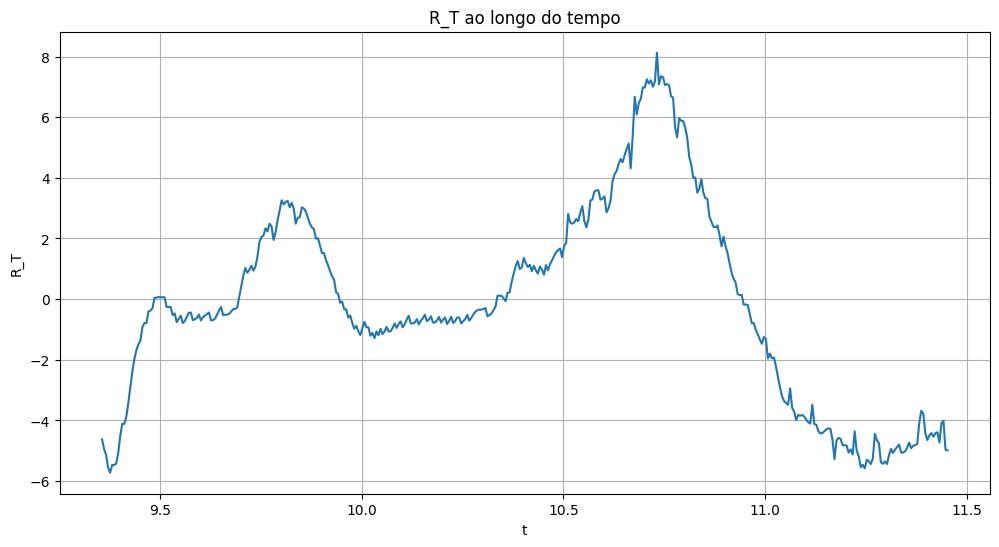

In [48]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(data['t'].iloc[:420], data['R_T'].iloc[:420])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

# 2º Passo: Cálculo do torque de interação τ_i

In [49]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i'])

<ipython-input-49-ada45a1a3584>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
<ipython-input-49-ada45a1a3584>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['d_tau_i'] = np.gradient(data['tau_i'])


# 3º Passo: Separação e Normalização dos dados


In [50]:
dataset = data.copy()
X = dataset[['tau_i', 'd_tau_i', 'phase', 'R_T']].iloc[1450:]
y = dataset[['R_T']].iloc[1450:]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [51]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (8020, 420, 4)
Forma dos dados de saída: (8020, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [52]:
model_cnn_lstm = Sequential()

# Ajustar o input_shape para refletir o número de características (4)
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, 4)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# Ajustar a saída da CNN para a entrada da LSTM
# Não alterar a dimensão calculada (209, 64)
model_cnn_lstm.add(LSTM(64, return_sequences=True))
model_cnn_lstm.add(Dropout(0.2))

model_cnn_lstm.add(LSTM(32, return_sequences=False))
model_cnn_lstm.add(Dropout(0.2))

# Camada de saída
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

# Compilação do modelo
model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['MAE', 'MSE'])

# Resumo do modelo
model_cnn_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 418, 64)        │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 209, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 209, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 209, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,305 (180.88 KB)

 Trainable params: 46,305 (180.88 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [53]:
# Treinamento do modelo
history = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=16,            # Número de épocas ajustável
    batch_size=32,        # Lote para atualização dos pesos
    validation_split=0.2, # Separação para validação
    verbose=1             # Exibição detalhada do progresso
)

Epoch 1/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - MAE: 0.0843 - MSE: 0.0127 - loss: 0.6462 - val_MAE: 0.0297 - val_MSE: 0.0014 - val_loss: 0.6277
Epoch 2/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - MAE: 0.0357 - MSE: 0.0021 - loss: 0.6254 - val_MAE: 0.0246 - val_MSE: 9.9779e-04 - val_loss: 0.6267
Epoch 3/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - MAE: 0.0312 - MSE: 0.0016 - loss: 0.6236 - val_MAE: 0.0273 - val_MSE: 0.0011 - val_loss: 0.6271
Epoch 4/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 83s 250ms/step - MAE: 0.0301 - MSE: 0.0015 - loss: 0.6220 - val_MAE: 0.0199 - val_MSE: 6.2817e-04 - val_loss: 0.6259
Epoch 5/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 84s 258ms/step - MAE: 0.0253 - MSE: 0.0011 - loss: 0.6237 - val_MAE: 0.0187 - val_MSE: 5.7633e-04 - val_loss: 0.6258
Epoch 6/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - MAE: 0.0241 - MSE: 0.0010 - loss: 0.6227 - val_MAE: 0.0191 - val_MSE: 6.2820e-04 - val_loss: 0.6259
Epoch 7/16
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - MAE: 0.02

# 7º Passo: Avaliação e Previsão

In [54]:
y_pred_scaled = model_cnn_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step
R²: 0.9815365458573974
MAE: 0.3234 Nm
RMSE: 0.4050 Nm


# 8º Passo: Visualização das perdas (train vs validation)

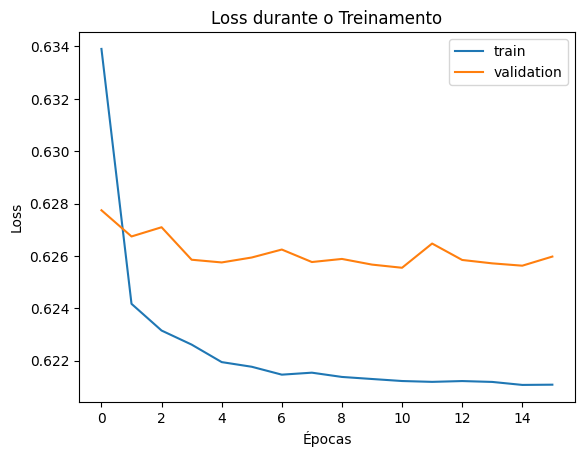

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

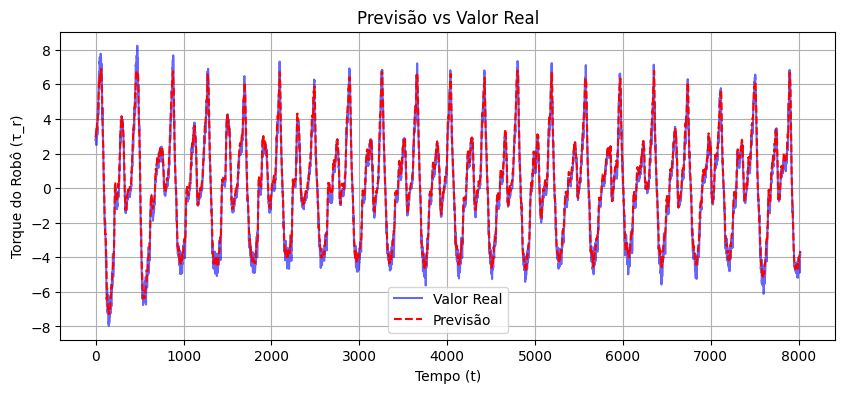

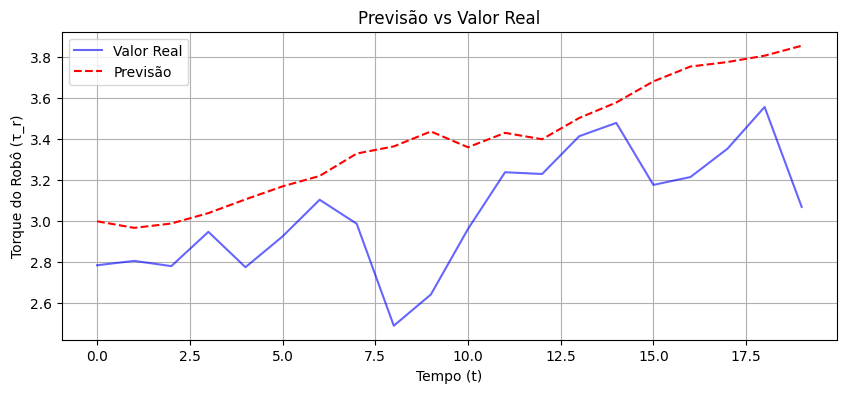

In [61]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:], y_pred[:])
plot_predictions(y_train_rescaled[:20], y_pred[:20])



# 10º Passo: Erro

In [58]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

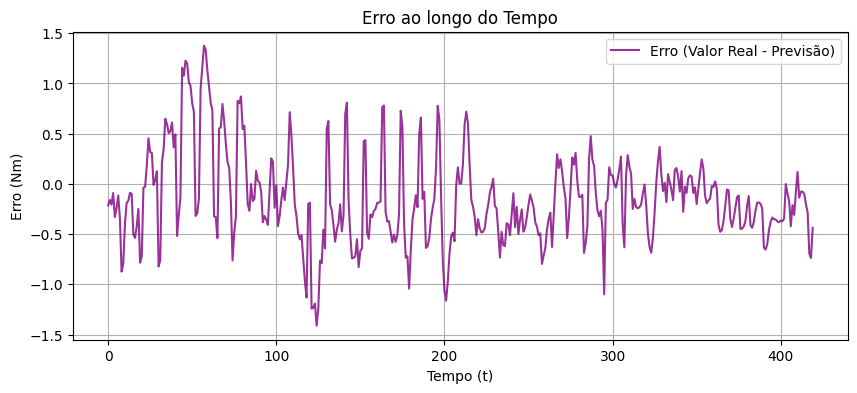

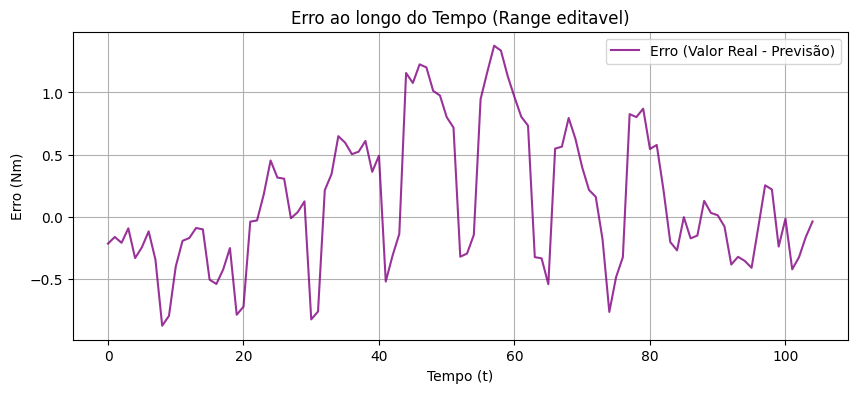

Média do Erro: -0.2172 Nm
Desvio Padrão do Erro: 0.3418 Nm


In [59]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:420], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:105], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')